#Per ottenere i vettori del vocabolario
https://github.com/vijayaiitk/NLP-text-classification-model/issues/1

Prendi le parole più simili
https://aneesha.medium.com/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229
https://stackoverflow.com/questions/37818426/get-most-similar-words-given-the-vector-of-the-word-not-the-word-itself
https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.most_similar.html

In [22]:
# usare i lessici

In [1]:
import pandas as pd
import nltk
import numpy as np
import string

import gensim
from mi_helper import *
from sklearn.pipeline import Pipeline

from numpy import array 
from numpy import dot
from numpy.linalg import norm

In [2]:
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases

In [3]:
from nltk import sent_tokenize
from nltk import pos_tag
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import wordnet
import re

In [4]:
custom_stopwords = ['echo',
 'alexa',
 'dot',
 "star",
 'amazon',
 'prime',
 '2nd',
 'generation',
 "fire",
 "stick",
 "firestick",
 "skype",
 "facetime",
 '1st',
 '3rd',
 '4th',
 '5th',
 "hub",
 "hulu",
 'google',
 'netflix',
 'youtube',
 'philip',
 'tp-link',
 'fourth',
 'roku',
 'i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'nor',
 'only',
 'own',
 'same',
 'so',
 'than',
 'too',
 'very',
 's',
 't',
 'can',
 'will',
 'just',
 'don',
 "...",
 'should',
 "should've",
 'now',
 'd',
 'll',
 'm',
 'o',
 're',
 've',
 'y',
 'ain',
 'aren',
 "aren't",
 'couldn',
 'didn',
 'doesn',
 'hadn',
 'hasn',
 'haven',
 'isn',
 'ma',
 'mightn',
 "mightn't",
 'mustn',
 "mustn't",
 'needn',
 "needn't",
 'shan',
 "shan't",
 'shouldn',
 'wasn',
 'weren',
 'won',
 'wouldn']

def negation_handler(sentence):	
    temp = int(0)
    for i in range(len(sentence)):
        if sentence[i-1] in ['not',"n't", "no", "without"]:
            antonyms = []
            for syn in wordnet.synsets(sentence[i]):
                syns = wordnet.synsets(sentence[i])
                w1 = syns[0].name()
                temp = 0
                for l in syn.lemmas():
                    if l.antonyms():
                        antonyms.append(l.antonyms()[0].name())
                max_dissimilarity = 0
                for ant in antonyms:
                    syns = wordnet.synsets(ant)
                    w2 = syns[0].name()
                    syns = wordnet.synsets(sentence[i])
                    w1 = syns[0].name()
                    word1 = wordnet.synset(w1)
                    word2 = wordnet.synset(w2)
                    if isinstance(word1.wup_similarity(word2), float) or isinstance(word1.wup_similarity(word2), int):
                        temp = 1 - word1.wup_similarity(word2)
                    if temp>max_dissimilarity:
                        max_dissimilarity = temp
                        antonym_max = ant
                        sentence[i] = antonym_max
                        sentence[i-1] = ''
    while '' in sentence:
        sentence.remove('')
    return sentence

In [6]:
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

In [5]:
dataset = pd.read_csv("amazon_alexa.tsv", sep = "\t")
dataset.tail()

rating       date   variation  \
3145       5  30-Jul-18  Black  Dot   
3146       5  30-Jul-18  Black  Dot   
3147       5  30-Jul-18  Black  Dot   
3148       5  30-Jul-18  White  Dot   
3149       4  29-Jul-18  Black  Dot   

                                       verified_reviews  feedback  
3145  Perfect for kids, adults and everyone in betwe...         1  
3146  Listening to music, searching locations, check...         1  
3147  I do love these things, i have them running my...         1  
3148  Only complaint I have is that the sound qualit...         1  
3149                                               Good         1

In [227]:
# dataset.drop(dataset[dataset.rating == 3].index, inplace=True) #droppa recensioni con 3-4 stelle
# dataset.drop(dataset[dataset.rating == 4].index, inplace=True)

In [228]:
# CREAZIONE DI UN SAMPLE DATASET BILANCIATO
# prende le prime n recensioni positive di lunghezza maggiore, dove n è il numero di recensioni negative
def create_balanced_dataset(dataset):
    """Bilancia il dataset uniformando il numero di recensioni negative e positive. Prende in input il dataset"""
    reviews_1 = list(dataset[dataset["feedback"] == 1]["verified_reviews"])
    reviews_0 = list(dataset[dataset["feedback"] == 0]["verified_reviews"])
    reviews_1.sort(key=len, reverse = True)
    sample_1 = reviews_1[:len(reviews_0)]
    verified_reviews_sample = []
    feedback_sample = []
    verified_reviews_sample.extend(sample_1)
    verified_reviews_sample.extend(reviews_0)
    feedback_sample.extend([1 for i in range(len(sample_1))])
    feedback_sample.extend([0 for i in range(len(reviews_0))])
    dataset = pd.DataFrame({"verified_reviews":verified_reviews_sample, "feedback": feedback_sample})
    print(dataset["feedback"].value_counts())
    return dataset


# dataset = create_balanced_dataset(dataset)

In [6]:
sentences = []

for review in dataset["verified_reviews"]:
    sents = sent_tokenize(review)
    for sent in sents:
        sentences.append(sent)
sentences

['Love my Echo!',
 'Loved it!',
 'Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you.',
 'I like being able to turn lights on and off while away from home.',
 'I have had a lot of fun with this thing.',
 'My 4 yr old learns about dinosaurs, i control the lights and play games like categories.',
 'Has nice sound when playing music as well.',
 'Music',
 'I received the echo as a gift.',
 'I needed another Bluetooth or something to play music easily accessible, and found this smart speaker.',
 'Can’t wait to see what else it can do.',
 'Without having a cellphone, I cannot use many of her features.',
 'I have an iPad but do not see that of any use.',
 'It IS a great alarm.',
 'If u r almost deaf, you can hear her alarm in the bedroom from out in the living room, so that is reason enough to keep her.It is fun to ask random questions to hear her response.',
 'She does not seem to be very smartbon politics yet.',
 "

In [7]:
def get_wordnet_pos(treebank_tag):
    """
    return WORDNET POS compliance to WORDENT lemmatization (a,n,r,v) 
    """
    if treebank_tag.startswith('J'):
        return "a"
    elif treebank_tag.startswith('V'):
        return "v"
    elif treebank_tag.startswith('N'):
        return "n"
    elif treebank_tag.startswith('R'):
        return "r"
    else:
        return "n"
        
pos_list = ["JJ", "JJR", "JJS", "RB", "RBR", "RBS", "VB", "VBD", "VBG", "VBN", "VBP", "VBZ"]

def tokenize_list_of_text(list_of_text, custom_stopwords = [], pos_filter = False, pos_list = []):
    """Tokenizza tutte le recensioni, pulisce da stopwords, elimina token <= 2 caratteri e lemmatizza. Ritorna la colonna delle recensioni."""

    tokenizer = nltk.tokenize.TweetTokenizer()
    lemmatizer = nltk.WordNetLemmatizer()
    detokenizer = TreebankWordDetokenizer()

    tokenized_reviews = []
    sent_tokenized_reviews = []
    for review in list_of_text: #pulisce le recensioni
        review = re.sub(r'\d+', '', review)
        clean_text = ""
        tokens = nltk.tokenize.word_tokenize(review, language='english', preserve_line=False)
        tokens = negation_handler(tokens)
        tokens = [w.lower() for w in tokens]
        tokens_pos = pos_tag(tokens)
        lemmatized_tokens = [(lemmatizer.lemmatize(w, get_wordnet_pos(pos)), pos) for w, pos in tokens_pos]
        if pos_filter:
            clean_tokens = [(w, pos) for w, pos in lemmatized_tokens if w not in string.punctuation and len(w)>2 and w not in custom_stopwords and pos in pos_list]
        else:
            clean_tokens = [(w, pos) for w, pos in lemmatized_tokens if w not in string.punctuation and len(w)>2 and w not in custom_stopwords]
        sent_tokenized_reviews.append([w for w, pos in clean_tokens])
        tokenized_reviews.append(detokenizer.detokenize([w for w, pos in clean_tokens]))
    
    n_tokens = []
    for sent in sent_tokenized_reviews:
        for w in sent:
            n_tokens.append(w)
    print("total number of tokens extracted are:", len(set(n_tokens)))
    return tokenized_reviews,  sent_tokenized_reviews # ritorna una tupla!

In [8]:
new_text, new_sent_tok = tokenize_list_of_text(dataset["verified_reviews"], custom_stopwords, False, pos_list)
# contengono una lista di tutte le frasi pre processate, nella prima variabile in stringa, nella seconda in tokens 

total number of tokens extracted are: 3345


In [9]:
bigrams = Phrases(new_sent_tok)
bigrams[new_sent_tok][34]

['device', 'awesome']

In [13]:
#window = numero di token, min_num = frequenza minima dei token, sg = traing algorithm - skip-gram, negative = negative example
#aggiorna soltato un numero k di pesi nella rete per le parole più informative 

# w2v_model = Word2Vec(bigrams[new_sent_tok], vector_size=100, window = 3, min_count = 5, sg=1, epochs=15, hs = 1)
# 100, 3, 5, skipgram

w2v_model = Word2Vec(bigrams[new_sent_tok], vector_size=300, window = 5, min_count = 5, sg=1, hs = 1, alpha=0.03, min_alpha=0.0007)
w2v_model.train(bigrams[new_sent_tok], total_examples=len(bigrams[new_sent_tok]), epochs=100, report_delay=1)
# w2v_model = Word2Vec(new_sent_tok, vector_size=100, window = 2, min_count = 5, sg=0, epochs=20, hs = 1)

(2367806, 3439800)

In [14]:
len(w2v_model.wv.vectors)

1030

In [15]:
w2v_model.wv.most_similar(['love'], topn = 2000) #Nearest neighboor --> high cosine similarity

[('neat', 0.2216722071170807),
 ('quick', 0.2085111439228058),
 ('cook', 0.19332629442214966),
 ('watching', 0.18227778375148773),
 ('recipe', 0.18225669860839844),
 ('great', 0.17932948470115662),
 ('jump', 0.17761100828647614),
 ('grand', 0.17305448651313782),
 ('much', 0.17242008447647095),
 ('trailer', 0.16791564226150513),
 ('sooner', 0.16685882210731506),
 ('improvement', 0.1661454290151596),
 ('bought', 0.16572239995002747),
 ('one', 0.16533051431179047),
 ('convenient', 0.16294388473033905),
 ('watch_movie', 0.16246667504310608),
 ('request', 0.16234588623046875),
 ('game', 0.16208195686340332),
 ('old', 0.16178177297115326),
 ('satisfy', 0.1611759215593338),
 ('absolutely_love', 0.16074050962924957),
 ('library', 0.15780901908874512),
 ('ease', 0.15734346210956573),
 ('touch', 0.1556466519832611),
 ('happy_purchase', 0.15457989275455475),
 ('life', 0.15435439348220825),
 ('shopping_list', 0.15432821214199066),
 ('grandchild', 0.15347808599472046),
 ('blast', 0.1526345759630203

In [16]:
w2v_model.wv.most_similar(['love'], topn = len(w2v_model.wv.vectors))[-20:] # less similar words

[('screen', -0.028323495760560036),
 ('correctly', -0.02867622673511505),
 ('fill', -0.029145337641239166),
 ('hate', -0.029326362535357475),
 ('voice_activate', -0.02954433485865593),
 ('hop', -0.03185662254691124),
 ('update', -0.03425867483019829),
 ('perform', -0.035065650939941406),
 ('six', -0.03516194969415665),
 ('functionality', -0.0367492139339447),
 ('source', -0.039930716156959534),
 ('spend', -0.043335992842912674),
 ('hue_bulb', -0.043595749884843826),
 ('reset', -0.044875938445329666),
 ('believe', -0.05638854578137398),
 ('item', -0.0567704401910305),
 ('expensive', -0.06060214340686798),
 ('issue', -0.06330714374780655),
 ('case', -0.0657423809170723),
 ('full', -0.0779213085770607)]

In [17]:
w2v_model.wv.vectors[0] # contiene i vettori

array([ 0.13602208,  0.15439753, -0.35331213,  0.24266282,  0.07881743,
       -0.2719808 , -0.03303904,  0.18553348, -0.16108151, -0.13061287,
        0.09630617,  0.06559644, -0.06151713,  0.23901892, -0.1606874 ,
       -0.12174372,  0.00336525,  0.04988092, -0.12453863, -0.05697469,
       -0.1749666 , -0.02646358,  0.07285762, -0.28028196,  0.21285687,
        0.03897445, -0.06228774,  0.07757501, -0.19475415,  0.14311245,
        0.35959178,  0.11211666,  0.20423308,  0.05650741, -0.05413089,
       -0.39433876,  0.08138746, -0.09095282,  0.2812826 ,  0.20718303,
       -0.08310266,  0.04225189, -0.13754216, -0.07973312, -0.13609158,
        0.0244866 , -0.2826547 , -0.01176049,  0.02202029,  0.04449852,
       -0.16660789, -0.21239318, -0.00480016,  0.17466861,  0.15640062,
        0.07629058,  0.10148695, -0.24645981, -0.25683138, -0.02750956,
       -0.04463874, -0.16567741,  0.20777239, -0.16188312, -0.12122788,
        0.04122489, -0.16903006,  0.16742621,  0.19762646,  0.09

The structure is called “KeyedVectors” and is essentially a mapping between keys and vectors. Each vector is identified by its lookup key, most often a short string token, so this is usually a mapping between {str => 1D numpy array}
https://radimrehurek.com/gensim/models/keyedvectors.html

Other useful internals in Gensim 4.0+ include model.wv.index_to_key, a plain list of the key (word) in each index position, and model.wv.key_to_index, a plain dict mapping keys (words) to their index positions.

In [18]:
w2v_model.wv.key_to_index

{'love': 0,
 'great': 1,
 'use': 2,
 'like': 3,
 'get': 4,
 'work': 5,
 'good': 6,
 'one': 7,
 'device': 8,
 'music': 9,
 'sound': 10,
 'not': 11,
 'buy': 12,
 'product': 13,
 'speaker': 14,
 'time': 15,
 'thing': 16,
 'would': 17,
 'show': 18,
 'easy': 19,
 'set': 20,
 'really': 21,
 'new': 22,
 'day': 23,
 'much': 24,
 'also': 25,
 'home': 26,
 'purchase': 27,
 'play': 28,
 'want': 29,
 'need': 30,
 'far': 31,
 'make': 32,
 'ask': 33,
 'play_music': 34,
 'well': 35,
 'fun': 36,
 'say': 37,
 'connect': 38,
 "n't": 39,
 'still': 40,
 'easy_set': 41,
 'plus': 42,
 'everything': 43,
 'smart': 44,
 'little': 45,
 'think': 46,
 'screen': 47,
 'tell': 48,
 'room': 49,
 'able': 50,
 'even': 51,
 'spot': 52,
 'could': 53,
 'feature': 54,
 'nice': 55,
 'sound_quality': 56,
 'light': 57,
 'see': 58,
 'try': 59,
 'add': 60,
 'price': 61,
 'house': 62,
 'find': 63,
 'lack': 64,
 'give': 65,
 'come': 66,
 'way': 67,
 'know': 68,
 'bedroom': 69,
 'learn': 70,
 'turn': 71,
 'small': 72,
 'weather': 

In [19]:
w2v = dict(zip(w2v_model.wv.index_to_key, w2v_model.wv.vectors))
w2v

{'love': array([ 0.13602208,  0.15439753, -0.35331213,  0.24266282,  0.07881743,
        -0.2719808 , -0.03303904,  0.18553348, -0.16108151, -0.13061287,
         0.09630617,  0.06559644, -0.06151713,  0.23901892, -0.1606874 ,
        -0.12174372,  0.00336525,  0.04988092, -0.12453863, -0.05697469,
        -0.1749666 , -0.02646358,  0.07285762, -0.28028196,  0.21285687,
         0.03897445, -0.06228774,  0.07757501, -0.19475415,  0.14311245,
         0.35959178,  0.11211666,  0.20423308,  0.05650741, -0.05413089,
        -0.39433876,  0.08138746, -0.09095282,  0.2812826 ,  0.20718303,
        -0.08310266,  0.04225189, -0.13754216, -0.07973312, -0.13609158,
         0.0244866 , -0.2826547 , -0.01176049,  0.02202029,  0.04449852,
        -0.16660789, -0.21239318, -0.00480016,  0.17466861,  0.15640062,
         0.07629058,  0.10148695, -0.24645981, -0.25683138, -0.02750956,
        -0.04463874, -0.16567741,  0.20777239, -0.16188312, -0.12122788,
         0.04122489, -0.16903006,  0.167426

In [20]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statistics 
#from plotnine import *
import plotly.express as px
import plotly.graph_objects as go

from sklearn.metrics import *
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics.pairwise import cosine_similarity

from kneed import KneeLocator

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import SilhouetteVisualizer


#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram

In [21]:
vectors=w2v_model.wv.vectors
len(vectors)

1030

In [22]:
words = w2v_model.wv.index_to_key
len(words)

1030

In [23]:
sse_list = []
silhouette_list = []
for k in range(2, 51):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300)
    kmeans.fit(vectors)
    sse_list.append(kmeans.inertia_)
    silhouette_list.append(silhouette_score(vectors,kmeans.labels_))

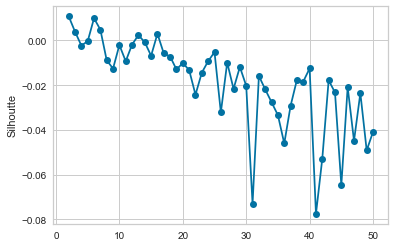

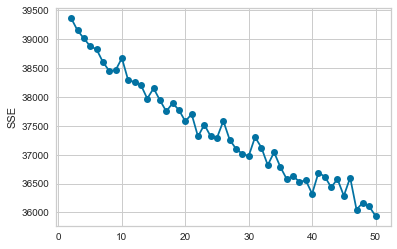

In [24]:
plt.plot(range(2, len(silhouette_list)+2), silhouette_list, marker='o')
plt.ylabel('Silhoutte')
plt.show()
plt.plot(range(2, len(sse_list)+2), sse_list, marker='o')
plt.ylabel('SSE')
plt.show()

In [25]:
kmeans = KMeans(n_clusters=2, n_init=10, max_iter=300)
kmeans.fit(vectors)

KMeans(n_clusters=2)

In [26]:
centers=kmeans.cluster_centers_ # centroidi
labels=kmeans.labels_ # clusters labels
np.unique(labels, return_counts=True) 

(array([0, 1]), array([274, 756], dtype=int64))

In [27]:
len(centers)

2

In [28]:
for i in centers:
    print(w2v_model.wv.most_similar(i, topn=40))
    print("####################################################")

[('shower', 0.4789193570613861), ('grand', 0.4319400489330292), ('appointment', 0.42637380957603455), ('lyric_song', 0.4236258268356323), ('favorite_song', 0.4232232868671417), ('audible_book', 0.41879716515541077), ('library', 0.4183080494403839), ('every_morning', 0.41315722465515137), ('rid', 0.41212770342826843), ('general', 0.4104023277759552), ('trailer', 0.41017305850982666), ('phenomenal', 0.4100612998008728), ('component', 0.4095713496208191), ('trivia', 0.40445077419281006), ('father_day', 0.3973369002342224), ('wake_morning', 0.39544835686683655), ('briefing', 0.39390403032302856), ('......', 0.3879397511482239), ('watching', 0.3868681490421295), ('heard', 0.38631537556648254), ('still_discover', 0.38495197892189026), ('lyric', 0.38319131731987), ('alex', 0.38260719180107117), ('joke', 0.38002443313598633), ('anymore', 0.3794777989387512), ('remind', 0.3793794512748718), ('game', 0.3781765103340149), ('artist', 0.3739665150642395), ('fios', 0.373447448015213), ('rock', 0.372

In [29]:
df = pd.DataFrame()

In [30]:
print(len(w2v["love"]))
print(len(centers[0])) # to check if the vectors have the same length

300
300


In [29]:
words = []
labels = []
cos = []
for w, label in zip(w2v, kmeans.labels_):
    words.append(w)
    labels.append(label)
    # this calculates the similarity bewtween centroids and all the words in their clusters
    cos_sim = dot(w2v[w], centers[label])/(norm(w2v[w])*norm(centers[label])) # cosine similarity formula (dot(a, b)/norm(a)*norm(b))
    cos.append(cos_sim)
    
df["word"] = words
df["labels"] = labels
df["cos"] = cos

print(df[df["labels"] == 1].sort_values(by = "cos", ascending = False).to_markdown()) # shows the most similar words to that cluster

|      | word             |   labels |      cos |
|-----:|:-----------------|---------:|---------:|
| 1002 | general          |        1 | 0.61234  |
| 1027 | appointment      |        1 | 0.593875 |
|    0 | love             |        1 | 0.580932 |
|  554 | every_morning    |        1 | 0.571315 |
|  879 | lyric_song       |        1 | 0.566235 |
|  989 | shower           |        1 | 0.554989 |
|  990 | briefing         |        1 | 0.549205 |
|  582 | shopping_list    |        1 | 0.546776 |
|  788 | wake_morning     |        1 | 0.540983 |
|  791 | trivia           |        1 | 0.540973 |
|  909 | heard            |        1 | 0.538864 |
|  949 | trailer          |        1 | 0.538779 |
|  872 | school           |        1 | 0.534889 |
| 1005 | library          |        1 | 0.534859 |
|  609 | podcasts         |        1 | 0.529304 |
|  343 | game             |        1 | 0.52729  |
|  312 | morning          |        1 | 0.524162 |
|  875 | audible_book     |        1 | 0.522098 |


In [30]:
from sklearn.manifold import TSNE

In [31]:
tsne = TSNE(3, learning_rate="auto", metric="cosine")
tokens_list = []
for vec in w2v_model.wv.vectors:
    tokens_list.append(vec)

In [32]:
new_val = tsne.fit_transform(np.array(tokens_list))

c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [33]:
df["x"] = [x[0] for x in new_val]
df["y"] = [x[1] for x in new_val]
df["z"] = [x[2] for x in new_val]

In [34]:
print(df[df["labels"] == 1].sort_values(by = "cos", ascending = False).to_markdown())

|      | word             |   labels |      cos |          x |           y |            z |
|-----:|:-----------------|---------:|---------:|-----------:|------------:|-------------:|
| 1002 | general          |        1 | 0.61234  | -24.9897   |   0.599402  | -12.4038     |
| 1027 | appointment      |        1 | 0.593875 | -37.0722   |   8.04035   |  -4.59097    |
|    0 | love             |        1 | 0.580932 | -23.5543   |  32.1753    | -16.9866     |
|  554 | every_morning    |        1 | 0.571315 | -31.0107   |   1.84934   |  -2.77503    |
|  879 | lyric_song       |        1 | 0.566235 | -38.9163   |  -1.91827   | -16.2057     |
|  989 | shower           |        1 | 0.554989 | -42.4763   |  -9.83061   |  -2.35208    |
|  990 | briefing         |        1 | 0.549205 | -35.3294   |   4.21208   | -10.9581     |
|  582 | shopping_list    |        1 | 0.546776 | -28.7553   |  -4.17865   | -13.8799     |
|  788 | wake_morning     |        1 | 0.540983 | -29.4806   |   4.76466   |   2

In [35]:
import seaborn as sns

<AxesSubplot:xlabel='x', ylabel='y'>

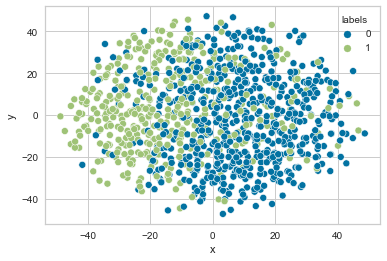

In [36]:
sns.scatterplot(data = df, x = "x", y = "y", hue = "labels")

In [37]:
import plotly_express as px

In [38]:
px.scatter_3d(data_frame = df, x = "x", y = "y", z = "z", color = [str(x) for x in df["labels"]], hover_name = "word")

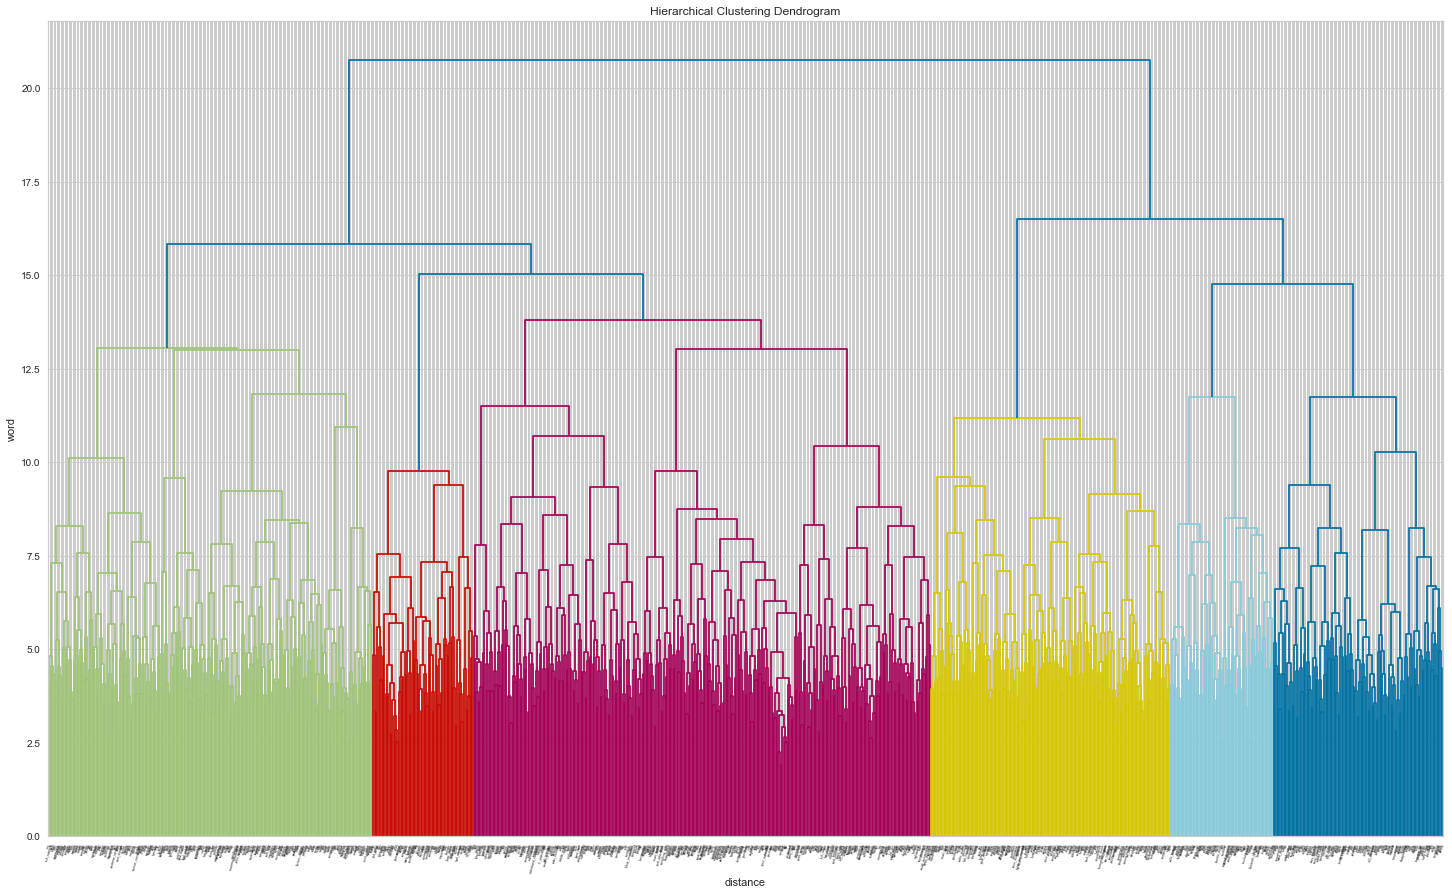

In [39]:
# distance_matrix = pairwise_distances(vectors, vectors, metric = "cosine")
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

l = linkage(w2v_model.wv.vectors, method='ward', metric='euclidean')

# calculate full dendrogram
plt.figure(figsize=(25, 15))
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('word')
plt.xlabel('distance')

dendrogram(
    l,
    leaf_rotation=75.,  # rotates the x axis labels
    leaf_font_size=3.,  # font size for the x axis labels
    leaf_label_func=lambda v: str(w2v_model.wv.index_to_key[v])
)
plt.show()

In [40]:
hier_df = pd.DataFrame()

hier_labels = fcluster(l, 2, "maxclust")
hier_df["labels"] = hier_labels

hier_df["x"] = df["x"]
hier_df["y"] = df["y"]
hier_df["z"] = df["z"]
hier_df["word"] = df["word"]
print(hier_df[hier_df["labels"] == 4].to_markdown())

| labels   | x   | y   | z   | word   |
|----------|-----|-----|-----|--------|


In [41]:
px.scatter_3d(data_frame = hier_df, x = "x", y = "y", z = "z", color = [str(x) for x in hier_df["labels"]], hover_name = "word")

In [42]:
w2v_model.wv.most_similar(['love'], topn = 2000) #Nearest neighboor --> high cosine similarity

[('great', 0.5743112564086914),
 ('like', 0.5253594517707825),
 ('grand', 0.48562249541282654),
 ('homework', 0.44984281063079834),
 ('watching', 0.4462510347366333),
 ('outstanding', 0.4440355896949768),
 ('lyric_song', 0.4435833692550659),
 ('see_lyric', 0.4343516528606415),
 ('really_enjoy', 0.4329974949359894),
 ('daughter', 0.4291297495365143),
 ('fun', 0.41914623975753784),
 ('joke', 0.41291409730911255),
 ('mother', 0.4125719964504242),
 ('every_room', 0.39840105175971985),
 ('dad', 0.39768269658088684),
 ('highly_recommend', 0.39722713828086853),
 ('neat', 0.396049827337265),
 ('advertised', 0.3953924775123596),
 ('seriously', 0.3950595557689667),
 ('mom', 0.3941199481487274),
 ('ton', 0.39228349924087524),
 ('one', 0.39131462574005127),
 ('everything', 0.38897013664245605),
 ('instantly', 0.3879947066307068),
 ('absolutely_love', 0.38571956753730774),
 ('kid', 0.3853985369205475),
 ('recipe', 0.38440385460853577),
 ('lyric', 0.3841017484664917),
 ('everyday', 0.379946798086166

In [31]:
# THIS CALCULATES DISTANCES BEWTWEEN EACH WORD AND THE POSITIVE-NEGATIVE CENTROID

df_polarity = pd.DataFrame()

words = []
positive_centroid = "love"
negative_centroid = "issue"
positive = []
negative = []

for w in w2v:
    words.append(w)
    pos = dot(w2v[w], w2v[positive_centroid])/(norm(w2v[w])*norm(w2v[positive_centroid]))
    neg = dot(w2v[w], w2v[negative_centroid])/(norm(w2v[w])*norm(w2v[negative_centroid]))
    # neg = 1-pos
    positive.append(pos)
    negative.append(neg)

df_polarity["word"] = words
df_polarity["pos_score"] = positive
df_polarity["neg_score"] = negative

df_polarity.sort_values(by = "neg_score", ascending = False).head(15)

word  pos_score  neg_score
100           issue  -0.063307   1.000000
889     electronics   0.009109   0.246224
700           reach   0.062415   0.229885
1023         effort   0.084884   0.211928
919        solution   0.011102   0.202285
985       frustrate   0.046682   0.199519
473         quickly   0.043506   0.196506
688          repair   0.017247   0.192521
461   user_friendly   0.097864   0.191778
356         picture   0.082155   0.190562
895       excelente   0.022800   0.189474
995     iheartradio  -0.003121   0.185411
699             saw   0.030945   0.185052
646           minor   0.097705   0.184853
299         overall   0.039874   0.183793

In [51]:
w2v_model.wv.most_similar(['love'], topn = 2000)[-20:] #Nearest neighboor --> high cosine similarity

[('screen', -0.028323495760560036),
 ('correctly', -0.02867622673511505),
 ('fill', -0.029145337641239166),
 ('hate', -0.029326362535357475),
 ('voice_activate', -0.02954433485865593),
 ('hop', -0.03185662254691124),
 ('update', -0.03425867483019829),
 ('perform', -0.035065650939941406),
 ('six', -0.03516194969415665),
 ('functionality', -0.0367492139339447),
 ('source', -0.039930716156959534),
 ('spend', -0.043335992842912674),
 ('hue_bulb', -0.043595749884843826),
 ('reset', -0.044875938445329666),
 ('believe', -0.05638854578137398),
 ('item', -0.0567704401910305),
 ('expensive', -0.06060214340686798),
 ('issue', -0.06330714374780655),
 ('case', -0.0657423809170723),
 ('full', -0.0779213085770607)]

In [33]:
def scoring_function(x, pos_w, neg_w, w2v):
    bigrams_clean = Phrases(x)
    # print(clean)
    predicted = []
    i = 0
    for review in bigrams_clean[x]:
        score = 0
        for w in review:
            try:
                vec = w2v[w]
                pos = dot(vec, w2v[pos_w])/(norm(vec)*norm(w2v[pos_w]))
                neg = dot(vec, w2v[neg_w])/(norm(vec)*norm(w2v[neg_w]))
                score += pos
                score -= neg
            except KeyError:
                continue
        if score > 0:
            predicted.append(1)
        elif score < 0:
            predicted.append(0)
        else:
            predicted.append(0)
        i+=1

    return predicted

In [34]:
def scoring_functionV3(x, pos_list, neg_list, w2v, stampa = True):
    import statistics
    bigrams_clean = Phrases(x)
    # print(clean)
    predicted = []
    for review in bigrams_clean[x]:
        pos_score = 0
        neg_score = 0
        for w in review:
            pos_sim_list = []
            neg_sim_list = []
            try:
                vec = w2v[w]
            except KeyError:
                continue
            for w_pos, w_neg in zip(pos_list, neg_list):
                pos_sim = dot(vec, w2v[w_pos])/(norm(vec)*norm(w2v[w_pos]))
                neg_sim = dot(vec, w2v[w_neg])/(norm(vec)*norm(w2v[w_neg]))  
                pos_sim_list.append(pos_sim) 
                neg_sim_list.append(neg_sim)
            pos = statistics.mean(pos_sim_list)
            neg = statistics.mean(neg_sim_list)
            if stampa:
                print(w, "pos:", pos, "neg:", neg)
            pos_score += statistics.mean(pos_sim_list)
            neg_score += statistics.mean(neg_sim_list)

        if pos_score>neg_score:
            predicted.append(1)
        elif pos_score<neg_score:
            predicted.append(0)
        else:
            predicted.append(0)
    
    return predicted

In [35]:
target_pos = ["love", "enjoy", "work_perfectly", "great"]
target_neg = ["trouble", "reset", "fix", "terrible", "disappointed", "issue"]
# target_pos = ["love", "enjoy", "great"]
# target_neg = ["reset", "fix", "terrible", "disappointed"]

import statistics

df_score_v3 = pd.DataFrame()

words = []
pos_score = []
neg_score = []

for w, vec in w2v.items():
    pos_sim_list = []
    neg_sim_list = []
    for w_pos, w_neg in zip(target_pos, target_neg):
        pos_sim = dot(vec, w2v[w_pos])/(norm(vec)*norm(w2v[w_pos]))
        neg_sim = dot(vec, w2v[w_neg])/(norm(vec)*norm(w2v[w_neg]))  
        pos_sim_list.append(pos_sim) 
        neg_sim_list.append(neg_sim)
    pos = statistics.mean(pos_sim_list)
    neg = statistics.mean(neg_sim_list)
    words.append(w)
    pos_score.append(pos_sim)
    neg_score.append(neg_sim)

df_score_v3["words"] = words
df_score_v3["pos"] = pos_score
df_score_v3["neg"] = neg_score

df_score_v3.sort_values(by = "neg", ascending = False).head(15)

words       pos       neg
438           terrible  0.081872  1.000000
943           straight  0.160777  0.324760
805            forward  0.159001  0.301487
936           negative  0.075546  0.298135
994     simultaneously  0.061953  0.276772
969           horrible  0.071603  0.271360
316            upgrade -0.034194  0.254418
677   definitely_worth  0.116774  0.246218
738    everything_else -0.001509  0.240845
816           intercom  0.038067  0.237716
609           podcasts  0.107996  0.236790
818             speech  0.061942  0.236698
201            however  0.012421  0.220111
1022       application  0.092116  0.216815
743   customer_service  0.080844  0.214176

In [36]:
w2v_model.wv.most_similar(['love'], topn = 2000) #Nearest neighboor --> high cosine similarity

[('neat', 0.2216722071170807),
 ('quick', 0.2085111439228058),
 ('cook', 0.19332629442214966),
 ('watching', 0.18227778375148773),
 ('recipe', 0.18225669860839844),
 ('great', 0.17932948470115662),
 ('jump', 0.17761100828647614),
 ('grand', 0.17305448651313782),
 ('much', 0.17242008447647095),
 ('trailer', 0.16791564226150513),
 ('sooner', 0.16685882210731506),
 ('improvement', 0.1661454290151596),
 ('bought', 0.16572239995002747),
 ('one', 0.16533051431179047),
 ('convenient', 0.16294388473033905),
 ('watch_movie', 0.16246667504310608),
 ('request', 0.16234588623046875),
 ('game', 0.16208195686340332),
 ('old', 0.16178177297115326),
 ('satisfy', 0.1611759215593338),
 ('absolutely_love', 0.16074050962924957),
 ('library', 0.15780901908874512),
 ('ease', 0.15734346210956573),
 ('touch', 0.1556466519832611),
 ('happy_purchase', 0.15457989275455475),
 ('life', 0.15435439348220825),
 ('shopping_list', 0.15432821214199066),
 ('grandchild', 0.15347808599472046),
 ('blast', 0.1526345759630203

In [48]:
def scoring_functionV4(x, pos_list, neg_list, w2v, stampa = True):
    import statistics
    bigrams_clean = Phrases(x)
    # print(clean)
    predicted = []
    average_pos = np.copy(w2v_model.wv.get_vector(pos_list[0]))
    average_neg = np.copy(w2v_model.wv.get_vector(neg_list[0]))
    for w_pos, w_neg in zip(pos_list[1:], neg_list[1:]):
            average_pos += w2v_model.wv.get_vector(w_pos)
            average_neg += w2v_model.wv.get_vector(w_neg)
    
    # average_pos = average_pos/norm(average_pos)
    # average_neg = average_neg/norm(average_neg)

    for review in bigrams_clean[x]:
        pos_score = 0
        neg_score = 0
        for w in review:
            try:
                vec = w2v[w]
            except KeyError:
                continue

            pos = dot(vec, average_pos)/(norm(vec)*norm(average_pos))
            neg = dot(vec, average_neg)/(norm(vec)*norm(average_neg))


            if stampa:
                print(w, "pos:", pos, "neg:", neg)
            pos_score += pos
            neg_score += neg

        if pos_score>neg_score:
            predicted.append(1)
        elif pos_score<neg_score:
            predicted.append(0)
        else:
            predicted.append(0)
    
    return predicted

In [49]:
y = []
x = []

dataset.drop(dataset[dataset.rating == 3].index, inplace=True) #droppa recensioni con 3-4 stelle
dataset.drop(dataset[dataset.rating == 4].index, inplace=True)
# dataset_test = create_balanced_dataset(dataset)
for feedback, review in zip(dataset["feedback"], dataset["verified_reviews"]):
    y.append(feedback)
    x.append(review)
    
x_test = tokenize_list_of_text(x, custom_stopwords, False, pos_list)[1]

total number of tokens extracted are: 2767


In [52]:
target_pos = ["love", "enjoy", "work_perfectly", "great", "awesome", "cool"]
target_neg = ["trouble", "reset", "fix", "error", "disappointed", "hate"]
predicted = scoring_function(x_test, "love", "trouble", w2v.copy())
print(classification_report(y, predicted))
predicted = scoring_functionV3(x_test, target_pos, target_neg, w2v.copy(), stampa = False)
print(classification_report(y, predicted))
predicted = scoring_functionV4(x_test, target_pos, target_neg, w2v.copy(), stampa = False)
print(classification_report(y, predicted))

              precision    recall  f1-score   support

           0       0.31      0.60      0.40       257
           1       0.95      0.85      0.90      2286

    accuracy                           0.82      2543
   macro avg       0.63      0.72      0.65      2543
weighted avg       0.88      0.82      0.85      2543

              precision    recall  f1-score   support

           0       0.38      0.77      0.51       257
           1       0.97      0.86      0.91      2286

    accuracy                           0.85      2543
   macro avg       0.68      0.81      0.71      2543
weighted avg       0.91      0.85      0.87      2543

              precision    recall  f1-score   support

           0       0.37      0.80      0.51       257
           1       0.97      0.85      0.91      2286

    accuracy                           0.84      2543
   macro avg       0.67      0.83      0.71      2543
weighted avg       0.91      0.84      0.87      2543



In [40]:
for pred, review, correct in zip(predicted, x, y):
    print("prediction:", pred, "true label:", correct)
    print(review)
    print("################")

prediction: 1 true label: 1
Love my Echo!
################
prediction: 1 true label: 1
Loved it!
################
prediction: 1 true label: 1
I have had a lot of fun with this thing. My 4 yr old learns about dinosaurs, i control the lights and play games like categories. Has nice sound when playing music as well.
################
prediction: 1 true label: 1
Music
################
prediction: 1 true label: 1
I received the echo as a gift. I needed another Bluetooth or something to play music easily accessible, and found this smart speaker. Can’t wait to see what else it can do.
################
prediction: 1 true label: 1
I think this is the 5th one I've purchased. I'm working on getting one in every room of my house. I really like what features they offer specifily playing music on all Echos and controlling the lights throughout my house.
################
prediction: 1 true label: 1
looks great
################
prediction: 1 true label: 1
Love it! I’ve listened to songs I haven’t heard

In [41]:
negation_handler(["not", "cheap"])

['expensive']

In [42]:
stringa = """It's got great sound and bass but it doesn't work all of the time. Its still hot or miss when it recognizes things"""

In [43]:
x = tokenize_list_of_text([stringa], custom_stopwords, False, pos_list)[1]
scoring_functionV3(x, target_pos, target_neg, w2v)

total number of tokens extracted are: 11
get pos: 0.06550738 neg: 0.04665817
great pos: 0.33005312 neg: 0.0139023755
sound pos: 0.04595291 neg: 0.039128516
bass pos: 0.053652957 neg: 0.009657117
idle pos: 0.0069881626 neg: 0.17805576
time pos: 0.061501004 neg: 0.06890833
still pos: 0.069151305 neg: 0.066608876
miss pos: 0.076434016 neg: 0.10764213
recognize pos: 0.08571927 neg: 0.09661486
thing pos: 0.072080866 neg: 0.06226957


[1]

In [47]:
w2v_model.wv.relative_cosine_similarity("love", "disappoint")

0.02744953903278287